In [1]:
import matplotlib.pyplot as plt
import librosa
import torchaudio
import numpy as np
import torch
import torchyin
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import soundfile as sf

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

eps = 1e-5

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(
/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Creating W from single note audio files

In [2]:
single_note = "test-data/single-notes-2"

In [3]:
W, freqs, sample_rate, true_freqs = init.init_W(single_note)
# W, freqs, sample_rate = init.init_W()
W_max = spec.max_columns(W)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


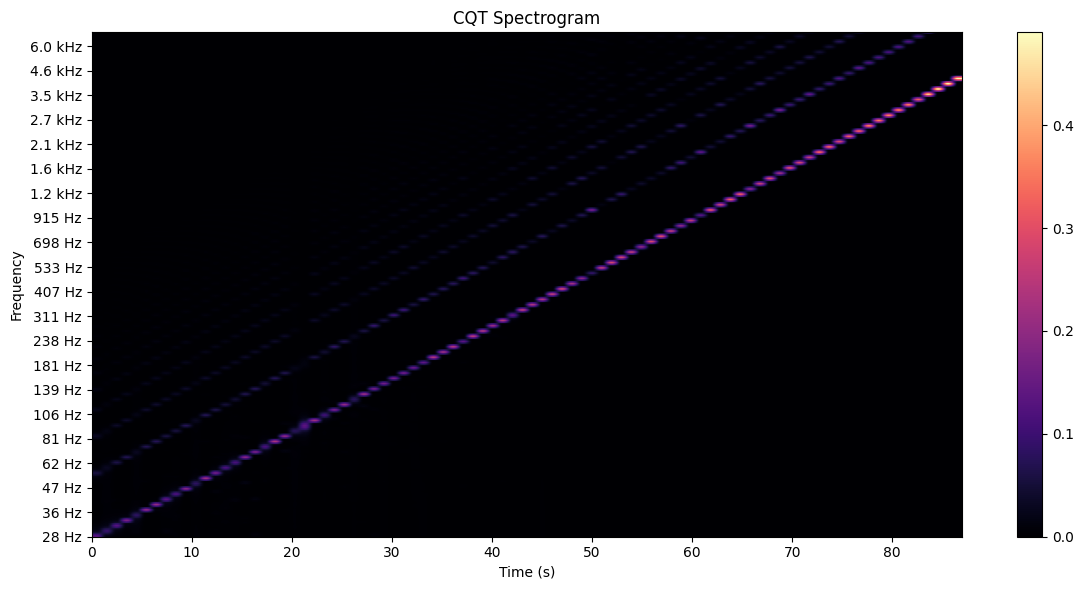

In [4]:
spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1], add_C8=False)

### Running MU iterations on a simple example from init W

In [5]:
number = 6
waveform_test, sample_rate_test = torchaudio.load(f"dataset/audios/example-{number}.wav")
cqt_test, times_test, freq_test = spec.cqt_spec(waveform_test, sample_rate_test, 256)

# spec.vis_cqt_spectrogram(cqt_test, times_test, freq_test, 0, times_test[-1])
midi, times = spec.midi_to_pianoroll(f"dataset/midis/example-{number}.mid", waveform_test, times_test, hop_length=128)
onset, offset = utils.detect_onset_offset(midi)
active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]

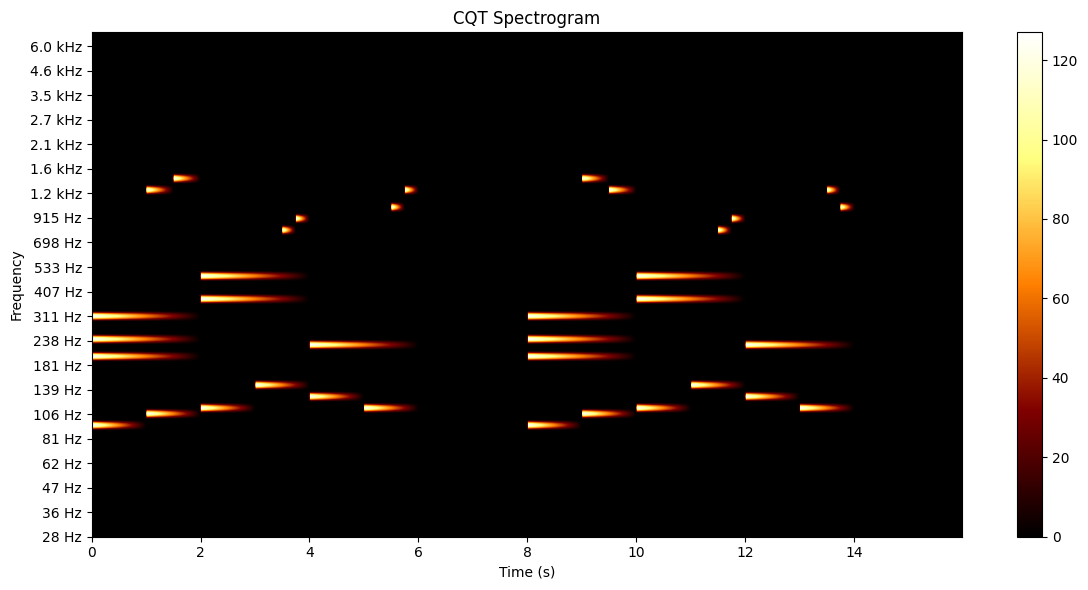

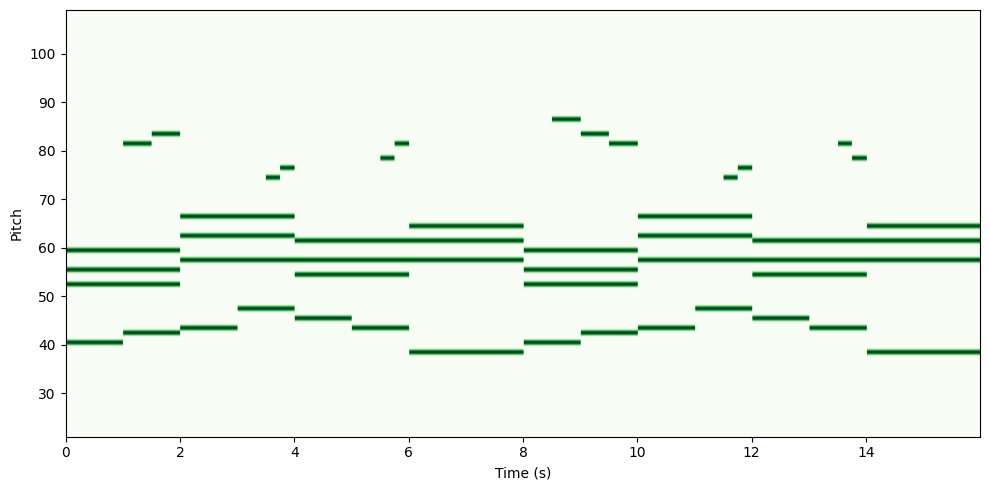

In [6]:
H = init.MIDI_to_W(midi, active_midi)
spec.vis_cqt_spectrogram(H, times_test, freq_test, 0, times_test[-1], cmap="afmhot")
# spec.vis_cqt_spectrogram(onset, times_test, freq_test, 0, times_test[-1], cmap="afmhot")
spec.vis_midi(midi, times, 0, times[-1])

In [7]:
f, t = cqt_test.shape
l = W.shape[1]
n_init_steps = 10

H = init.init_H(l, t, W, cqt_test, n_init_steps, beta=1)
# kernel = utils.gaussian_kernel(sigma=9, is_2d=True)
# H = utils.filter1d_tensor(H, kernel)

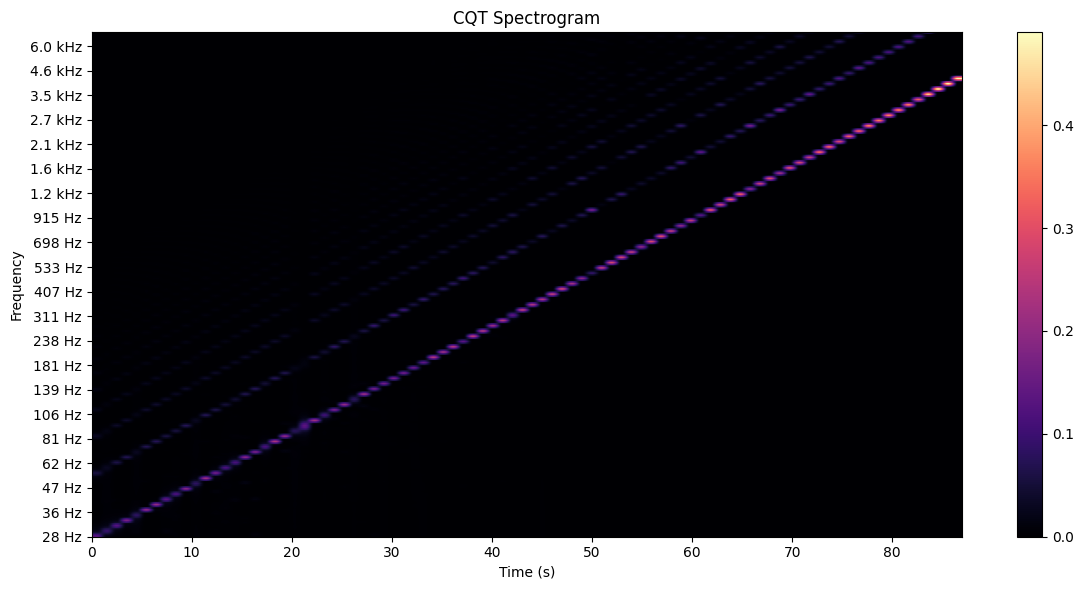

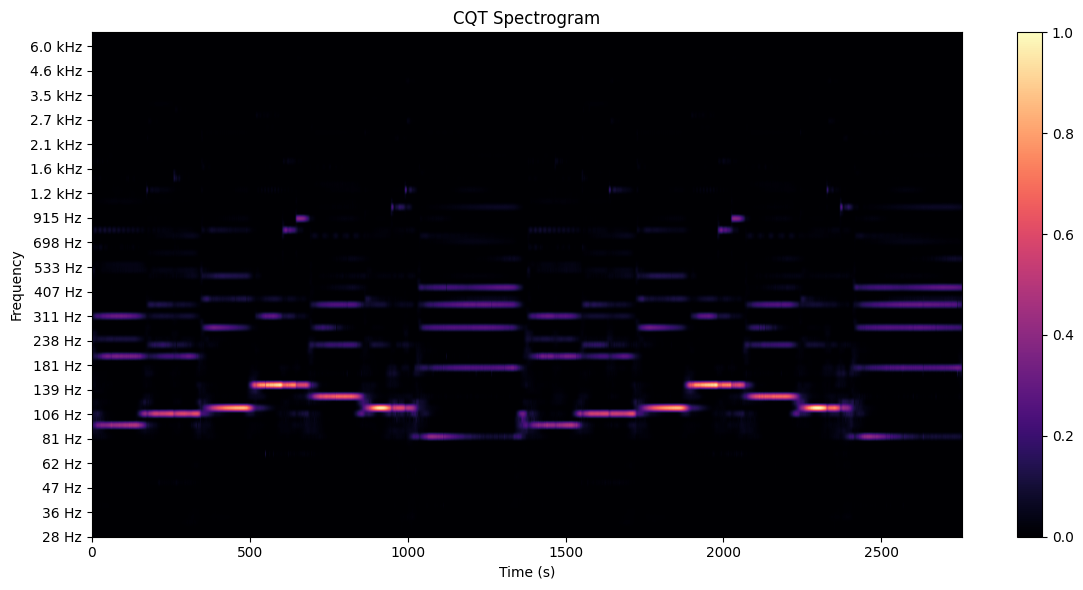

In [8]:
spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1], add_C8=False)
spec.vis_cqt_spectrogram(H, np.arange(H.shape[1]), freq_test, 0, H.shape[1], add_C8=False)

In [9]:
W, H, M_hat = models.MU_iter(cqt_test, 88, f, t, n_iter=1e4)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/models.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = torch.tensor(M)


TypeError: rand() received an invalid combination of arguments - got (float, int, int), but expected one of:
 * (tuple of ints size, *, torch.Generator generator, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.Generator generator, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [ ]:
spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1], add_C8=False)
spec.vis_cqt_spectrogram(H, np.arange(H.shape[1]), freq_test, 0, H.shape[1], add_C8=False)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


The model has 25344 parameters


/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


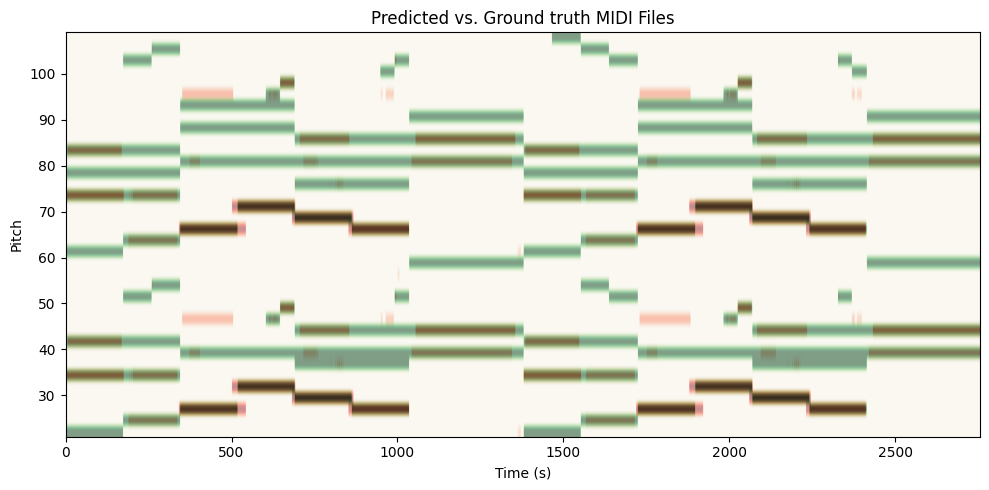

tensor(0.1991, grad_fn=<MseLossBackward0>)


In [29]:
model = models.NALMU(l, eps, beta=1, n_iter=10, W_path=single_note, n_init_steps=10, shared=True)
utils.model_infos(model, names=False)
device  = torch.device('cpu')
model.to(device=device)

model.init_H(cqt_test.squeeze(0))
M = cqt_test.to(device)
midi_batch = midi.to(device)

W_layers, H_layers, M_hats = model(M)

frequencies_predicted, notes_predicted = init.W_to_pitch(W_layers[-1], model.freqs, use_max=True)
midi_hat, active_midi_hat = init.WH_to_MIDI(W_layers[-1], H_layers[-1], notes_predicted, threshold=0.005, smoothing_window=5, adaptative=False, normalize=True)

midi_batch = midi_batch.squeeze(0)
active_midi = [i for i in range(88) if (midi_batch[i,:]>0).any().item()]
active_midi_hat = [i for i in range(88) if (midi_hat[i,:]>0).any().item()]
active = active_midi_hat + active_midi

# Blur the MIDIs before computing the MSE loss
sigma = 0.1
kernel = utils.gaussian_kernel(kernel_size=15, sigma=sigma, is_2d=True)
midi_batch = utils.filter1d_tensor(midi_batch, kernel, is_2d=True)
midi_hat = utils.filter1d_tensor(midi_hat, kernel, is_2d=True)

spec.compare_midi(midi_batch[active].detach().numpy(), midi_hat[active].detach().numpy(), np.arange(midi_hat.shape[1]), 0, midi_hat.shape[1])
crit = nn.MSELoss()
print(crit(midi_batch[active], midi_hat[active]))

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


The model has 25344 parameters
------- epoch 0, loss = 910.052 -------
------- epoch 1, loss = 459.957 -------
------- epoch 2, loss = 263.832 -------
------- epoch 3, loss = 164.479 -------
------- epoch 4, loss = 112.517 -------
------- epoch 5, loss = 82.188 -------
------- epoch 6, loss = 64.419 -------
------- epoch 7, loss = 51.216 -------
------- epoch 8, loss = 42.301 -------
------- epoch 9, loss = 35.716 -------


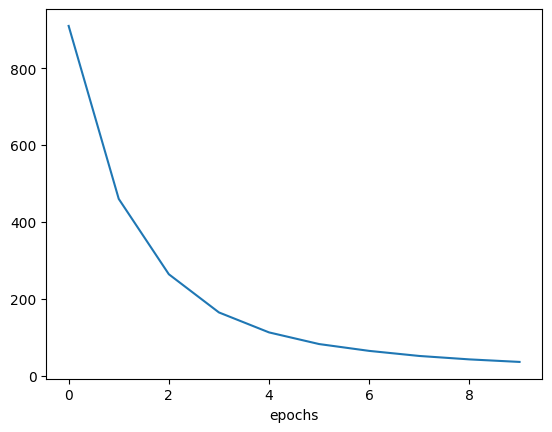

Grad norm: 0.00361328455619514
====== New audio file ======
Grad norm: 0.006519245449453592
====== New audio file ======
Grad norm: 0.008597717620432377
====== New audio file ======
Grad norm: 0.008987677283585072
====== New audio file ======
Grad norm: 0.01018607709556818
====== New audio file ======
Grad norm: 0.011661115102469921
====== New audio file ======
Grad norm: 0.013915250077843666
====== New audio file ======
Grad norm: 0.01419693510979414
====== New audio file ======
Grad norm: 0.014255348592996597
====== New audio file ======
Grad norm: 0.014510328881442547
====== New audio file ======
Grad norm: 0.02737906388938427
====== New audio file ======
------------ Epoch 0, loss = 0.20043 ------------
Grad norm: 0.028453290462493896
====== New audio file ======
Grad norm: 0.030183810740709305
====== New audio file ======
Grad norm: 0.03161713108420372
====== New audio file ======
Grad norm: 0.03182041272521019
====== New audio file ======
Grad norm: 0.033392373472452164
====== Ne

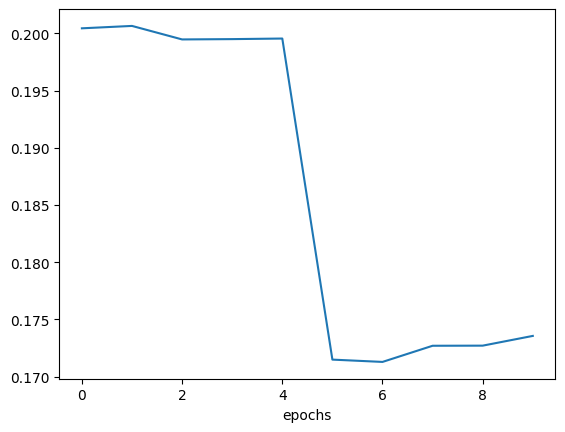

In [21]:
model = models.NALMU(l, eps, beta=1, n_iter=10, W_path=single_note, n_init_steps=10, shared=True)
utils.model_infos(model, names=False)
device  = torch.device('cpu')
model.to(device=device)
dataset = utils.MaestroNMFDataset("dataset/audios", "dataset/midis")
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

train1 = True
n_epochs1 = 10
optimizer1 = torch.optim.AdamW(model.parameters(), lr=1e-2)

train2 = True
n_epochs2 = 10
criterion = nn.MSELoss()
optimizer2 = torch.optim.AdamW(model.parameters(), lr=1e3)
optimizer2.zero_grad()

lambda_l    = torch.ones(model.n_iter)#torch.arange(0, 1, 1/model.n_iter)
# decay of the blurring across layers
start_value = 7
end_value   = 1
base        = (end_value / start_value) ** (1 / (model.n_iter - 1))
sigma       = torch.tensor([start_value * (base ** i) for i in range(model.n_iter)])

if train1:
    utils.warmup_train(model, n_epochs1, loader, optimizer1, device, print_grads=False)

if train2:
    losses   = []
    accumulation_steps = 5
    optimizer2.zero_grad()
    for j in range(n_epochs2):
        inter_loss = []
        for M, midi_batch in loader:
            model.init_H(M.squeeze(0))
            M = M.to(device)
            midi_batch = midi_batch.to(device)

            W_layers, H_layers, M_hats = model(M)
            # total_loss = 0
            
            frequencies_predicted, notes_predicted = init.W_to_pitch(W_layers[-1], model.freqs, use_max=True)
            midi_hat, active_midi_hat = init.WH_to_MIDI(W_layers[-1], H_layers[-1], notes_predicted, threshold=0.005, smoothing_window=5, adaptative=False, normalize=True)

            midi_batch = midi_batch.squeeze(0)
            active_midi = [i for i in range(88) if (midi_batch[i,:]>0).any().item()]
            active_midi_hat = [i for i in range(88) if (midi_hat[i,:]>0).any().item()]
            active = active_midi + active_midi_hat
            
            # Blur the MIDIs before computing the MSE loss
            # kernel = utils.gaussian_kernel(sigma=5, is_2d=True)
            # midi_batch = utils.filter1d_tensor(midi_batch, kernel)
            # midi_hat = utils.filter1d_tensor(midi_hat, kernel)
            
            # spec.compare_midi(midi_batch[active].detach().numpy(), midi_hat[active].detach().numpy(), np.arange(midi_hat.shape[1]), 0, midi_hat.shape[1])

            loss = criterion(midi_hat[active], midi_batch[active])
            inter_loss.append(loss.detach().numpy())
            loss.backward()
        
            # for layer in range(model.n_iter):
            #     W_hat = W_layers[layer]
            #     H_hat = H_layers[layer]
            #     M_hat = M_hats[layer]

            #     frequencies_predicted, notes_predicted = init.W_to_pitch(W_hat, model.freqs, use_max=True)
            #     midi_hat, active_midi_hat = init.WH_to_MIDI(W, H_hat, notes_predicted, threshold=0.005, smoothing_window=5, adaptative=False, normalize=True)

            #     midi_batch = midi_batch.squeeze(0)
            #     active_midi = [i for i in range(88) if (midi_batch[i,:]>0).any().item()]
                
            #     # Blur the MIDIs before computing the MSE loss
            #     kernel = utils.gaussian_kernel(sigma=sigma[layer], is_2d=True)
            #     midi_batch_f = utils.filter1d_tensor(midi_batch, kernel)
            #     midi_hat_f = utils.filter1d_tensor(midi_hat, kernel)

            #     loss = criterion(midi_hat_f[active_midi,:], midi_batch_f[active_midi,:])
            #     total_loss += lambda_l[layer] * loss
            #     inter_loss.append(total_loss.detach().numpy())

            # total_loss.backward()
            
            for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f"Grad norm: {param.grad.norm().item()}")
                else:
                    print(f"Grad is None for {name}")
            print("====== New audio file ======")
        
        if (j + 1) % accumulation_steps == 0:
            optimizer2.step()
            optimizer2.zero_grad()
        losses.append(np.mean(inter_loss)) 
        print(f"------------ Epoch {j}, loss = {np.mean(inter_loss):.5f} ------------") 

    plt.plot(losses, label='Transcription MSE loss over epochs')
    plt.xlabel('epochs')
    plt.show()

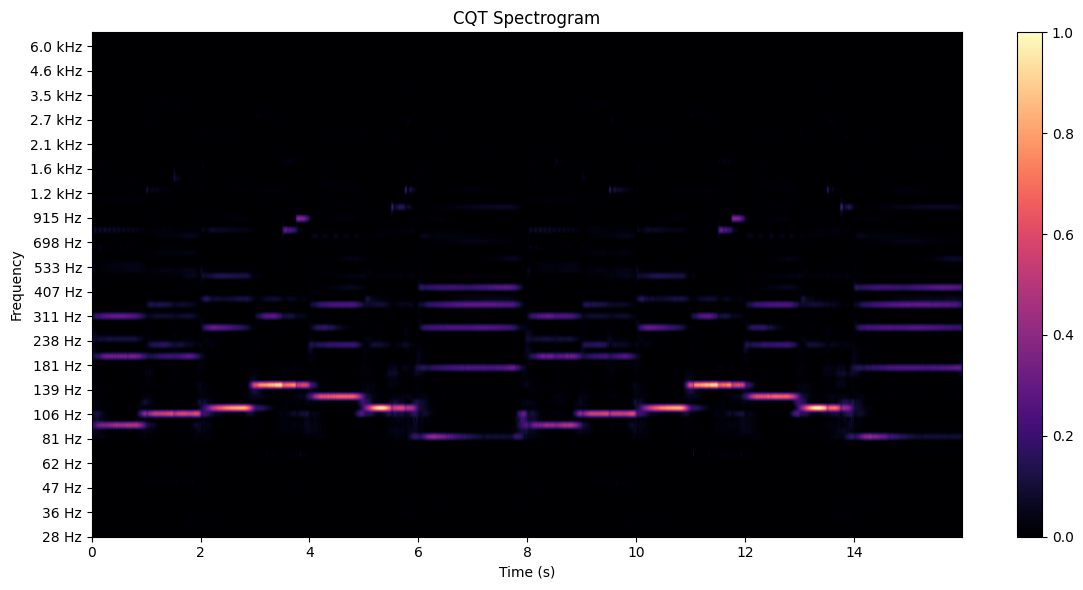

In [7]:
spec.vis_cqt_spectrogram(H, times_test, freqs, 0, times_test[-1])

#### Reconstructing the CQT from W and H:

In [8]:
M_hat = W @ H
# spec.vis_cqt_spectrogram(M_hat, times_test, freq_test, 0, times_test[-1])
# spec.vis_cqt_spectrogram(cqt_test, times_test, freq_test, 0, times_test[-1])

In [9]:
loss_function = nn.MSELoss()
loss = loss_function(M_hat, cqt_test)
diff = M_hat - cqt_test
loss

tensor(1.6103e-05)

### Retrieving frequencies and notes from W

In [10]:
frequencies_predicted, notes_predicted = init.W_to_pitch(W, true_freqs, use_max=True)
frequencies_gt, notes_gt = init.W_to_pitch(W, true_freqs, use_max=False)
# print(notes_predicted, len(notes_predicted))
# notes_new, W_new_rearranged = init.W2pitch(W_new, W, notes_gt)
# notes_new

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/init.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frequency = torch.tensor(frequency, dtype=torch.float32)


In [ ]:
# Visualize the evolution of W passing though several RALMU blocks
aw = models.Aw_cnn(hidden_channels=16)
block = models.RALMU_block(shared_aw=aw, use_ah=False)

W, freqs, sample_rate, true_freqs  = init.init_W(single_note)

waveform_test, sample_rate_test = torchaudio.load(f"dataset/audios/example-2.wav")
M, _, _ = spec.cqt_spec(waveform_test, sample_rate_test, 256)

f, t = M.shape
l = W.shape[1]
n_init_steps = 100
H = init.init_H(l, t, W, M, n_init_steps, beta=1)

# spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1])

W_hat, H_hat = block(M, W, H)
# spec.vis_cqt_spectrogram(W_hat.detach().numpy(), np.arange(W_hat.shape[1]), freqs, 0, W_hat.shape[1])

layers = 5

for i in range(layers):
    W_hat, H_hat = block(M, W_hat, H_hat)
    spec.vis_cqt_spectrogram(W_hat.detach().numpy(), np.arange(W_hat.shape[1]), freqs, 0, W_hat.shape[1])
    

In [ ]:
# Visualize the conv layers for Aw
fig, axs = plt.subplots((3), figsize=(10,30))
params = [param for param in aw.parameters() if len(param.shape)==3]
for i, param in enumerate(params):
    if len(param.shape) == 3:
        axs[i].imshow(param[:,0,:].detach().numpy(), aspect="auto")

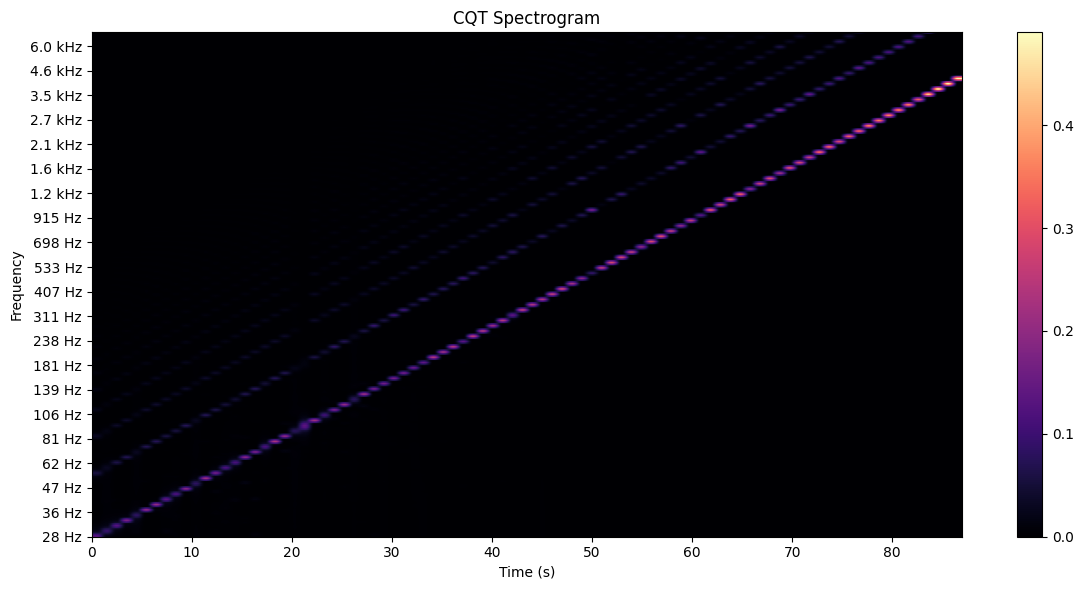

In [11]:
spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1])

In [12]:
diff = torch.abs(notes_predicted - notes_gt)
diff.sum()
diff

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.])

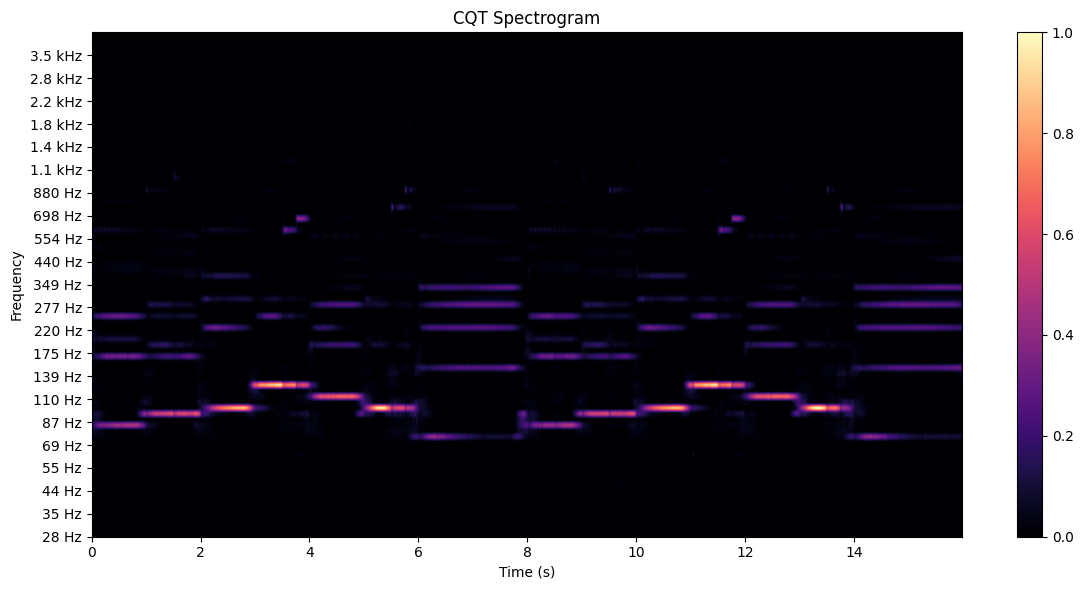

In [13]:
spec.vis_cqt_spectrogram(H, times_test, frequencies_predicted, 0, times_test[-1])

### Retrieving MIDI from W and H

In [14]:
midi_hat, active_midi_hat = init.WH_to_MIDI(W, H, notes_predicted, threshold=0.005, smoothing_window=5, adaptative=False, normalize=True)
active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]
# print(f"Detected {len(active_midi_hat)} notes, GT = {len(active_midi)}, same notes? {active_midi==active_midi_hat}")
# for i, (gt, predicted) in enumerate(zip(active_midi, active_midi_hat)):
#     if gt != predicted:
#         print(f"index {i}: {gt} ≠ {predicted}, diff = {abs(gt - predicted)}")

tensor1 = torch.tensor(active_midi)
tensor2 = torch.tensor(active_midi_hat)
unique_to_list1 = tensor1[~torch.isin(tensor1, tensor2)]
unique_to_list2 = tensor2[~torch.isin(tensor2, tensor1)]
print("Unique to gt:", ", ".join(map(str, unique_to_list1.tolist())))
print("Unique to prediction:", ", ".join(map(str, unique_to_list2.tolist())))

Unique to gt: 34, 41, 45, 62, 65
Unique to prediction: 14, 20, 23, 29


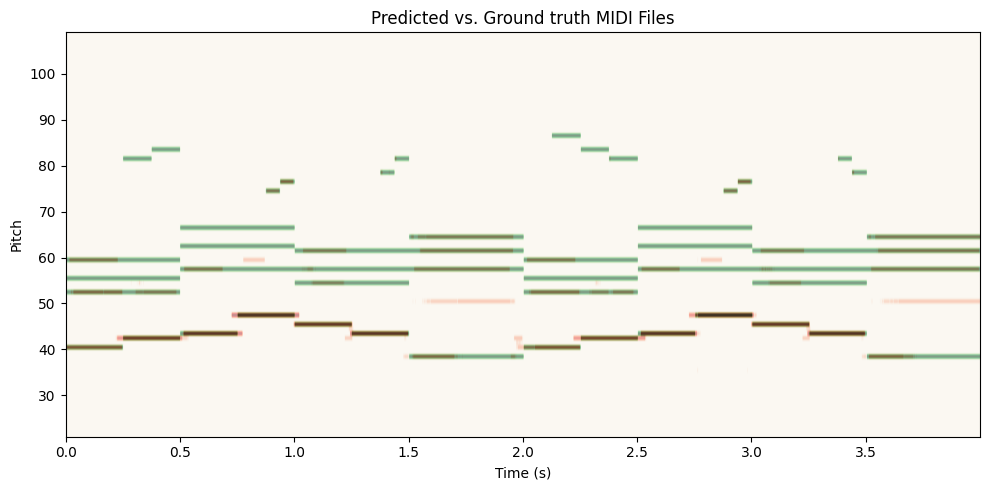

In [15]:
spec.compare_midi(midi, midi_hat, times_test, 0, 4)

In [16]:
criterion = nn.BCELoss()
loss = criterion(midi_hat[active_midi,:], midi[active_midi,:])
loss

tensor(10.6568)

### MIDI reconstruction

In [ ]:
midi_hat, active_midi = init.WH_to_MIDI(W, H, notes_predicted, threshold=0.01, smoothing_window=5, adaptative=False, normalize=True)
active_midi

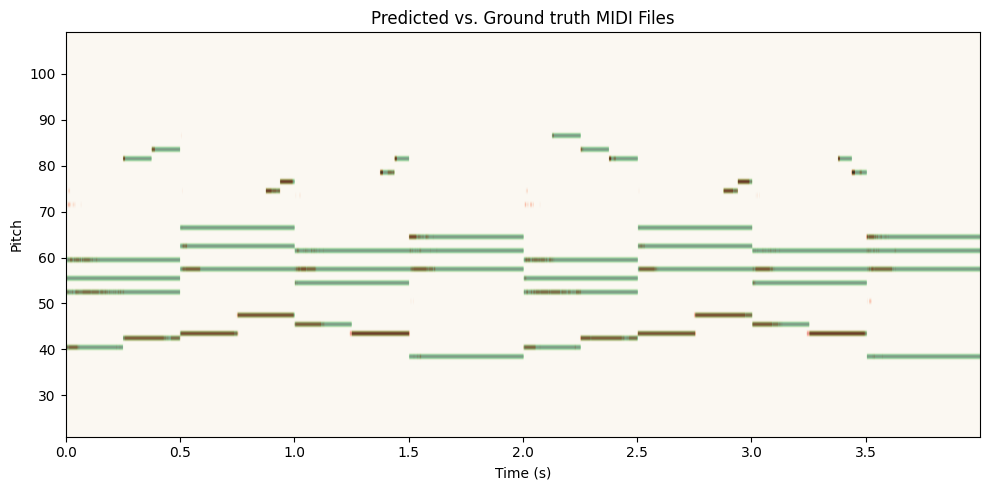

In [53]:
spec.compare_midi(midi, midi_hat, times_test, 0, 4)

### Training

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


The model has 1889 parameters
------- epoch 0, loss = 54.600 -------
------- epoch 1, loss = 28.182 -------
------- epoch 2, loss = 14.220 -------
------- epoch 3, loss = 7.837 -------
------- epoch 4, loss = 6.940 -------
------- epoch 5, loss = 6.082 -------
------- epoch 6, loss = 5.669 -------
------- epoch 7, loss = 5.551 -------
------- epoch 8, loss = 5.449 -------
------- epoch 9, loss = 5.423 -------


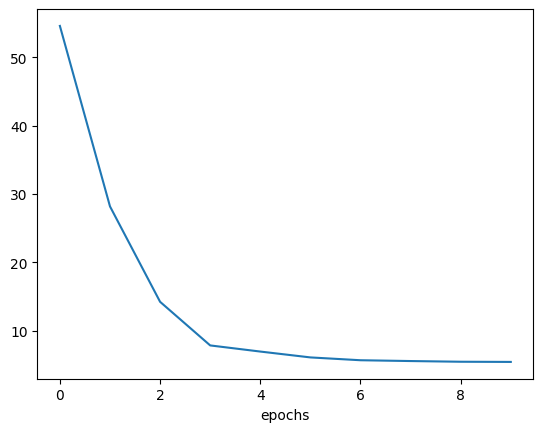

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/utils.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = torch.tensor(kernel, dtype=torch.float32).unsqueeze(0).unsqueeze(0)


====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
------------ Epoch 0, loss = 0.22089 ------------
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
------------ Epoch 1, loss = 0.22089 ------------
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
====== New audio file ======
=

KeyboardInterrupt: 

In [9]:
# model = models.RALMU(l, eps, beta=1, W_path=single_note, n_iter=5, shared=True)
model = models.RALMU(l, eps, beta=1, n_iter=5, W_path=single_note, n_init_steps=10, hidden=16, use_ah=False, shared=True) 
# model = models.RALMU(l, eps, beta=1, n_iter=5, n_init_steps=10, hidden=16, use_ah=False, shared=True) 
utils.model_infos(model, names=False)
device  = torch.device('cpu')
model.to(device=device)
dataset = utils.MaestroNMFDataset("dataset/audios", "dataset/midis")
loader  = DataLoader(dataset, batch_size=1, shuffle=False)

train1 = True
n_epochs1 = 10
optimizer1 = torch.optim.AdamW(model.parameters(), lr=1e-3)

train2 = True
n_epochs2 = 10
criterion = nn.MSELoss()
optimizer2 = torch.optim.AdamW(model.parameters(), lr=1e-2)
optimizer2.zero_grad()

lambda_l    = torch.ones(model.n_iter)#torch.arange(0, 1, 1/model.n_iter)
# decay of the blurring across layers
start_value = 7
end_value   = 1
base        = (end_value / start_value) ** (1 / (model.n_iter - 1))
sigma       = torch.tensor([start_value * (base ** i) for i in range(model.n_iter)])

if train1:
    utils.warmup_train(model, n_epochs1, loader, optimizer1, device)

if train2:
    losses   = []
    accumulation_steps = 5
    optimizer2.zero_grad()
    for j in range(n_epochs2):
        inter_loss = []
        for M, midi_batch in loader:
            model.init_H(M.squeeze(0))
            M = M.to(device)
            midi_batch = midi_batch.to(device)

            W_layers, H_layers, M_hats = model(M)
            total_loss = 0
            
            for layer in range(model.n_iter):
                W_hat = W_layers[layer]
                H_hat = H_layers[layer]
                M_hat = M_hats[layer]

                frequencies_predicted, notes_predicted = init.W_to_pitch(W_hat, model.freqs, use_max=True)
                # spec.vis_cqt_spectrogram(W_hat.detach().numpy(), np.arange(W_hat.shape[1]), frequencies_predicted, 0,W_hat.shape[1])
                # print(len(notes_predicted), notes_predicted.max())
                if notes_predicted.max() > 87:
                    spec.vis_cqt_spectrogram(W_hat.detach().numpy(), np.arange(W_hat.shape[1]), frequencies_predicted, 0,W_hat.shape[1])
                midi_hat, active_midi_hat = init.WH_to_MIDI(W, H_hat, notes_predicted, threshold=0.005, smoothing_window=5, adaptative=False, normalize=True)

                midi_batch = midi_batch.squeeze(0)
                active_midi = [i for i in range(88) if (midi_batch[i,:]>0).any().item()]
                
                # Blur the MIDIs before computing the MSE loss
                kernel = utils.gaussian_kernel(sigma=sigma[layer], is_2d=True)
                midi_batch_f = utils.filter1d_tensor(midi_batch, kernel)
                midi_hat_f = utils.filter1d_tensor(midi_hat, kernel)

                loss = criterion(midi_hat_f[active_midi,:], midi_batch_f[active_midi,:])
                total_loss += lambda_l[layer] * loss
                inter_loss.append(total_loss.detach().numpy())

            total_loss.backward()
            
            for name, param in model.named_parameters():
                if param.grad.norm().item() > 1e-1:
                    print(f"Grad norm: {param.grad.norm().item()}")
                # else:
                #     print(f"Grad is None for {name}")
            print("====== New audio file ======")
        
        if (j + 1) % accumulation_steps == 0:
            optimizer2.step()
            optimizer2.zero_grad()
        losses.append(np.mean(inter_loss)) 
        print(f"------------ Epoch {j}, loss = {np.mean(inter_loss):.5f} ------------") 

    plt.plot(losses, label='Transcription MSE loss over epochs')
    plt.xlabel('epochs')
    plt.show()

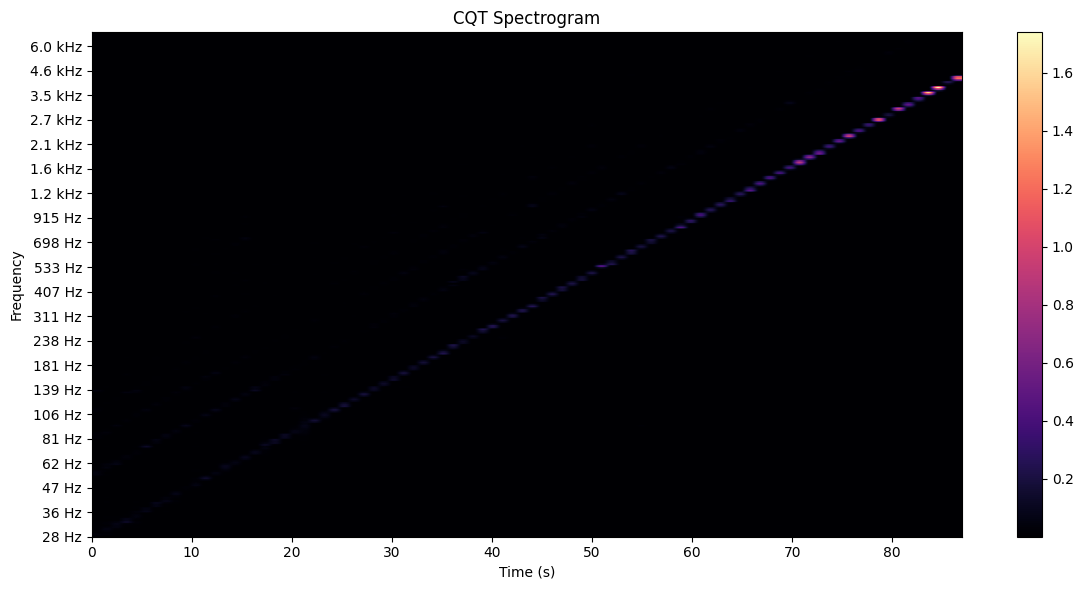

In [ ]:
# W, freqs, sample_rate  = init.init_W(single_note)

waveform_test, sample_rate_test = torchaudio.load(f"dataset/audios/example-2.wav")
M, _, _ = spec.cqt_spec(waveform_test, sample_rate_test, 256)

f, t = M.shape
l = W.shape[1]
n_init_steps = 100
H = init.init_H(l, t, W, M, n_init_steps, beta=1)

# spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1])
model.init_H(M.squeeze(0))
W_layers, H_layers, M_hats = model(M)
spec.vis_cqt_spectrogram(W_layers[-1].detach().numpy(), np.arange(W_layers[-1].shape[1]), freqs, 0, W_layers[-1].shape[1])    

In [8]:
notes = torch.empty(W_hat.shape[1])
pitches = torch.empty(W_hat.shape[1])
ids = torch.empty(W_hat.shape[1])

for i in range(W_hat.shape[1]):
    _, max_id = torch.max(W_hat[:,i], dim=0)
    ids[i] = max_id
    # print(max_id)
    freqs = librosa.cqt_frequencies(W_hat.shape[0], fmin=librosa.note_to_hz('A0'), bins_per_octave=36)
    freq = freqs[max_id] # Use freq with max amplitude in the CQT
    if freq >= 27.5 and freq <= 4186:
        pitches[i] = freq
    # print(pitch)
    notes[i] = init.frequency_to_note(pitches[i], thresh=0.4) - 21
print(ids.max(), pitches.max())

tensor(281.) tensor(3875.7200)


/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/init.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frequency = torch.tensor(frequency, dtype=torch.float32)


In [10]:
W = model.forward(cqt_test)
spec.vis_cqt_spectrogram(W.detach().numpy(), np.arange(W.shape[1]), freqs, 0, W.shape[1])

RuntimeError: The size of tensor a (1379) must match the size of tensor b (2757) at non-singleton dimension 2

In [16]:
loss = utils.loss_midi(midi_hat, midi)
loss

tensor(2078.7217)

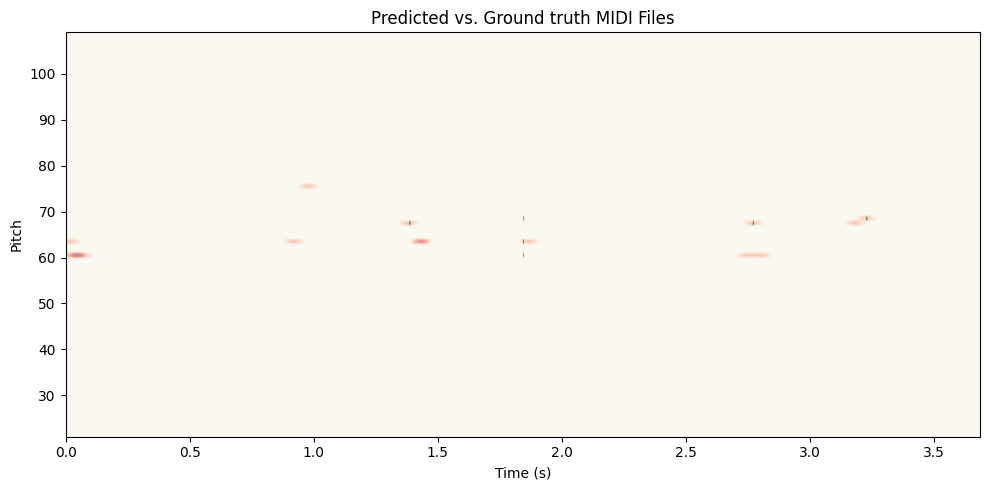

In [12]:
onset_hat, offset_hat = utils.detect_onset_offset(midi_hat, filter=True)
spec.compare_midi(onset,onset_hat, times_test, 0, times_test[-1])

In [ ]:
f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sr)

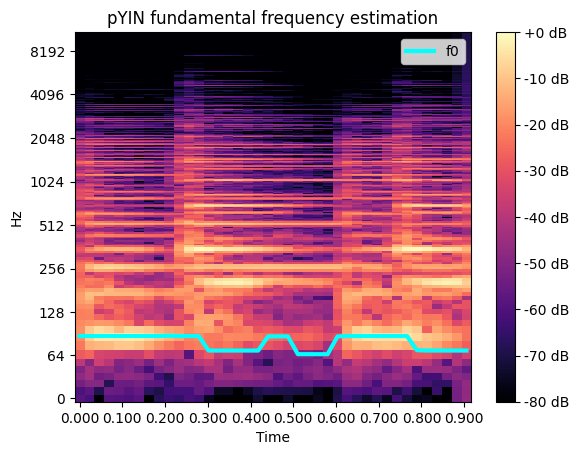

In [ ]:
import matplotlib.pyplot as plt
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')